# DM-28360: Generate catalogs to simulate phosim images 

Use the code from `PS1_phosim_generation`: 
* Query the 'aos_catalog_ps1' table in the 'lsstdevaosdb1' database at NCSA to select sources (assumed to be point sources) and return a Pandas catalog. 
* Write pandas catalog into the file format required by phosim (for images or an OPD). Note we do not set MJD or any of the other parameters required to set a non-dark sky background.

There used to be a writeup https://jira.lsstcorp.org/browse/DM-27797 , but this link https://community.lsst.org/t/using-postgresql-at-ncsa-for-an-apdb/4603 doesn't work ... 

"the db password for .pgpass is your NCSA password"

https://www.postgresql.org/docs/current/libpq-pgpass.html  says the file should be in "users home directory" and contain 

    hostname:port:database:username:password
    
So I would have 

    lsst-pgsql03.ncsa.illinois.edu:5432:lsstdevaosdb1:scichris:Zxsw,1234



First thing to do is to use psql and see if you can login and have the right permissions

    psql "host=lsst-pgsql03.ncsa.illinois.edu user=scichris dbname=lsstdevaosdb1 port=5432"
    
Now it works! 

In [1]:
from astropy.table import Table
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import Column
from astropy.table import join
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy import units as u

In [67]:
import psycopg2
dbName = 'lsstdevaosdb1'
host = 'lsst-pgsql03.ncsa.illinois.edu'
dbuser = 'scichris'
dbport = 5432
dbTable = 'aos_catalog_ps1'

connection = psycopg2.connect(dbname=dbName,
                              host=host,
                              port=dbport,
                              )

In [72]:
# These are the definitions of fields 
# at different galactic latitudes

gt = Table(data=[['high','med','low','Baade'],
                            [0,0,0,1.02],
                           [85,40,10,-3.92 ]], 
                      names=['name', 'l_deg','b_deg'])

gaia_coords = SkyCoord(l=gt['l_deg'],b=gt['b_deg'], 
                       frame='galactic', unit='deg')

gt['ra_deg'] = gaia_coords.icrs.ra.deg
gt['dec_deg'] = gaia_coords.icrs.dec.deg

# rewrite as dict for easier access of coordinates 
# of a specific field by name 
gt_dict = {}
for i in range(len(gt)):
    gt_dict[gt['name'][i]]  = {'ra':gt['ra_deg'][i], 
                               'dec':gt['dec_deg'][i]}
gt_dict

{'high': {'ra': 197.46441300863182, 'dec': 24.33554243027582},
 'med': {'ra': 233.01733592061046, 'dec': -4.447088188407341},
 'low': {'ra': 257.11044958320826, 'dec': -23.409732178640596},
 'Baade': {'ra': 270.88380338652223, 'dec': -30.035274475954893}}

The radius of the query will depend whether we need a full focal plane, or one raft only... 

Try doing just R22 (comCam) for now

In [99]:
#query database for sources within a given radius and return as a pandas dataframe
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

pandaCats = {}

instrument = 'comcam' # or comCam 
#for name in gt_dict.keys():

name='med' # test just one field ... 
ra = gt_dict[name]['ra']
dec = gt_dict[name]['dec']
print(ra,dec,name)
if instrument == 'lsstCam':
    radius = 2.5 # degrees : for famCam test ... 
elif instrument == 'comCam':
    radius = 0.4 # degrees - R22 only 

passband = "rmeanpsfmag"

queryString ='SELECT "objid", "ra", "dec", "{}" from "aos_catalog_ps1" where "ra" between {} and {} \
and "dec" between {} and {} and "rmeanpsfmag" > -900.;'.format(passband, ra-radius/np.cos(np.radians(dec)), 
                                                               ra+radius/np.cos(np.radians(dec)), 
                                                              dec-radius, dec+radius)
#print(queryString)
pandaCat = pd.read_sql_query(queryString, connection)
pandaCats[name] = pandaCat

#tableCat = Table.from_pandas(pandaCat)
#tableCat.write(name+'_PS1_comcam.txt',format='ascii', overwrite=True)

233.01733592061046 -4.447088188407341 med


Convert the stored txt catalogs (for ease of access) into phosim catalog (for usage by phosim):

In [81]:
import os

# NB:  here we only do 0.25 sec exposure to quickly test if the image is properly made 
# in generating large catalogs, change to 15 sec. 
def writePhosimHeader(output, ra, dec, camconfig=3, Opsim_filter=3, mjd=59580., exposure=0.25,
                     obsid=9006002, defocal=False):
    '''Write to file handle the phosim header'''
    output.write("Opsim_obshistid {}\n".format(obsid))
    output.write("Opsim_filter {}\n".format(Opsim_filter))
    output.write("mjd {}\n".format(mjd))
    output.write("SIM_SEED {}\n".format(1000))
    output.write("rightascension {}\n".format(ra))
    output.write("declination {}\n".format(dec))
    output.write("rotskypos {}\n".format(0.000000))
    output.write("rottelpos {}\n".format(0))
    output.write("SIM_VISTIME {}\n".format(exposure))
    output.write("SIM_NSNAP {}\n".format(1))
    output.write("moonphase {}\n".format(0.0))
    output.write("moonalt {}\n".format(-90))
    output.write("sunalt {}\n".format(-90))
    output.write("Opsim_rawseeing {}\n".format(-1))
    if defocal:
        output.write("move 10 -1500.0000\n") # write the defocal movement 
    output.write("camconfig {}\n".format(camconfig))

def writePhosimInstFile(pandaCat, ra, dec,  phosimFile="stars.cat", passband='r', outDir="./", camconfig=3, opd=False,
                       exposure=.25, obsid=9006002, defocal=False):
    '''Generate a phosim instance catalog from a Pandas dataframe'''
    
    passbands = {"u":"umeanpsfmag", 
                 "g":"gmeanpsfmag", 
                 "r":"rmeanpsfmag", 
                 "i":"imeanpsfmag", 
                 "z":"zmeanpsfmag", 
                 "y":"ymeanpsfmag", 
                }
    
    outFile = os.path.join(outDir, phosimFile)
    
    filterID = list(passbands.keys()).index(passband)
    with open(outFile,'w') as output:
        writePhosimHeader(output, ra, dec, camconfig=camconfig, Opsim_filter=filterID, mjd=59580.,
                         exposure=exposure, obsid=obsid, defocal=defocal)
        if (opd==True):
            output.write("opd 0 {} {} 500".format(ra,dec))
        else:
            for index, row in pandaCat.iterrows():
                output.write("object {} {} {} {} ../sky/sed_flat.txt 0.0 0.0 0.0 0.0 0.0 0.0 star 12.0 none none\n".format(
                    int(row["objid"]),row["ra"],row["dec"], row[passbands[passband]]))
    print('Saved as ', outFile)
    return outFile
                

def writePhosimCmdFile(root_dir, file_name='phosim.cmd', noBackground=True):
    '''
    Write a phosim physics commands file
    that is used to generate simulated images.
    Full reference https://bitbucket.org/phosim/phosim_release/wiki/Physics%20Commands 
    and https://bitbucket.org/phosim/phosim_release/wiki/Background%20Approximations 
    '''
    outFile = os.path.join(root_dir, file_name)
    with open(outFile,'w') as output:
        
        # choose whether to simulate background or not 
        if noBackground:
            output.write("backgroundmode 0\n")
        else:
            output.write("quickbackground\n")
            
        # write other options that are usually unchanged
        output.write("raydensity 0\n")  # X is the density of cosmic rays
        output.write("perturbationmode 1\n") # X=0: ideal design; X=1: ideal design+deliberate control (move commands); X=2: ideal design + non-controlled environmental/fabrication; X=3: all on (ideal design + deliberate control + non-controlled); Default is X=3
        output.write("trackingmode 0\n") # X=1: tracking on; X=0: tracking turned off; Default is X=1
        output.write("cleartracking\n") # resets all tracking to 0
        output.write("clearclouds\n") # resets all clouds to 0
        output.write("lascatprob 0.0\n")  #  (X is the large angle scattered light fraction)
        output.write("contaminationmode 0\n")  # X=1 dust/condensation ; X=0 perfect surfaces
        output.write("diffractionmode 1\n") # X=1: monte carlo diffraction; X=0 diffraction off; X=2 full FFT approach (very slow); Default is X=1
        output.write("straylight 0\n") 
        output.write("detectormode 0\n")  #  X=1: charge diffusion in detector on; X=0 charge diffusion off
        output.write("centroidfile 1\n") # X=1: output centroid files 
        
    print(f'Saved as {outFile}')
    return outFile 
    


In [101]:
# write the .cmd file
cmd_file = writePhosimCmdFile('/project/scichris/aos/ps1_phosim/', file_name='qckBkgnd.cmd', noBackground=False)

Saved as /project/scichris/aos/ps1_phosim/qckBkgnd.cmd


In [103]:
# write the .inst file 
path = '/project/scichris/aos/ps1_phosim/'
if not os.path.exists(path):
    os.makedirs(path)
#for name in pandaCats.keys():
name = 'med'    
defocal = 'inFocus'#'extra'
ra = gt_dict[name]['ra']
dec = gt_dict[name]['dec']
#instrument = 'lsstCam'

# for lsstFam + corner sensors , 
inst_file = writePhosimInstFile(pandaCats[name], ra, dec,  phosimFile=f"stars_{instrument}_PS1_{name}_{defocal}.inst", 
                       passband='r', outDir=path, exposure=0.25, obsid=9006002, defocal=False)


Saved as  /project/scichris/aos/ps1_phosim/stars_comcam_PS1_med_inFocus.inst


Run phosim. What I call `noBkgnd.cmd` is the same as `ts_phosim/policy/cmdFile/starDefault.cmd`. 

Do that on NCSA, `lsst-devl03`, since that's where phosim is configured to run:

    ssh scichris@lsst-login01.ncsa.illinois.edu 
    ssh lsst-devl03 
    source "/software/lsstsw/stack/loadLSST.bash"    # need that for python 
    setup lsst_distrib 


optionally, open a screen to preserve the session:

    screen -S lsstCamTest
    ctrl+A  :logfile screenlog_lsstCamTest_210401.txt
    ctrl+A , H  - to start recording screen output to  a file 
    
    ctrl+D - to detach from a screen 
    ctrl+X - to attach to a  screen 

## Make phosim command

In [48]:
phosim_path = '/project/scichris/aos/phosim_syseng4/phosim.py'
working_dir =  '/project/scichris/aos/ps1_phosim/'
#inst_file =  os.path.join(working_dir, 'stars_comcam_PS1_high_extra.inst')
#cmd_file = os.path.join(working_dir, 'noBkgnd.cmd')

instrument = 'comCam'
name = 'high'
defocal = 'inFocus_rot30'
inst_file = '/project/scichris/aos/ps1_phosim/stars_comcam_PS1_high_rot30.inst'
cmd_file = '/project/scichris/aos/ps1_phosim/noBkgnd.cmd'

if instrument == 'lsstCam':
    instr = 'lsst'
elif instrument == 'comCam':
    instr = 'comcam'
    
root_dir = os.path.join(working_dir, instrument, name, defocal)
out_dir =  os.path.join(root_dir, 'raw')

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
log_file = os.path.join(out_dir, 'starPhoSim.log')

command = f"python {phosim_path} {inst_file} -i {instr} -e 1 \
-c {cmd_file} -p 25 -o {out_dir} > {log_file} 2>&1"

print(command)

python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/ps1_phosim/stars_comcam_PS1_high_rot30.inst -i comcam -e 1 -c /project/scichris/aos/ps1_phosim/noBkgnd.cmd -p 25 -o /project/scichris/aos/ps1_phosim/comCam/high/inFocus_rot30/raw > /project/scichris/aos/ps1_phosim/comCam/high/inFocus_rot30/raw/starPhoSim.log 2>&1


phosim_repackager.py /project/scichris/aos/ps1_phosim/comCam/high/inFocus_rot30/raw/ --out_dir /project/scichris/aos/ps1_phosim/comCam/high/inFocus_rot30/repackaged/ --inst comcam

## Show comcam in-focus images:

First, need to repackage the raw phosim output:

    setup phosim_utils -r /project/scichris/aos/phosim_utils/
   
    phosim_repackager.py /project/scichris/aos/ps1_phosim/comcam/high/inFocus/raw/ --out_dir /project/scichris/aos/ps1_phosim/comcam/high/inFocus/repackaged/ --inst comcam 

Ingest as gen3 repo, runIsr, and show the result: 

    cd project/scichris/aos/ps1_phosim/comcam/high/inFocus/
    
    butler create DATA
    butler register-instrument DATA/ lsst.obs.lsst.LsstComCam
    butler ingest-raws DATA repackaged/
    
    butler define-visits DATA/ lsst.obs.lsst.LsstComCam
    butler write-curated-calibrations DATA/ lsst.obs.lsst.LsstComCam
    
    Use this pipeline stored in testPipeline.yaml :

    description: ISR basic processing pipeline
    instrument: lsst.obs.lsst.LsstCam
    tasks:
      isr:
        class: lsst.ip.isr.isrTask.IsrTask
        config:
          connections.outputExposure: 'postISRCCD'
          doBias: False
          doVariance: False
          doLinearize: False
          doCrosstalk: False
          doDefect: False
          doNanMasking: False
          doInterpolate: False
          doBrighterFatter: False
          doDark: False
          doFlat: False
          doApplyGains: True
          doFringe: False
          doOverscan: True
          
    pipetask run -j 9 -b DATA/ -i LSSTComCam/raw/all,LSSTComCam/calib -p testPipeline.yaml --register-dataset-types --output-run run1

In [97]:
from lsst.daf import butler as dafButler
import matplotlib.pyplot as plt
from matplotlib import rcParams 
from astropy.io import fits
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()

rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

path_to_repo = '/project/scichris/aos/ps1_phosim/comcam/high/inFocus/DATA/'
butler = dafButler.Butler(path_to_repo, instrument="LSSTComCam")


In [76]:
#Explore the repo:
registry = butler.registry
datasetRefs = list(registry.queryDatasets(datasetType='postISRCCD', collections=['run1']))
for ref in datasetRefs:
    print(ref.dataId)
    print(ref.dataId.keys())   

{instrument: 'LSSTCam', detector: 90, exposure: 4000021706001, ...}
{instrument, detector, exposure}


Show the postISRCCD for R22_S11 : 

Text(0.5, 1.0, 'LsstComCam, R22_S02 (ITL), high latitude, 0.25 sec exp \n backgroundmode 0')

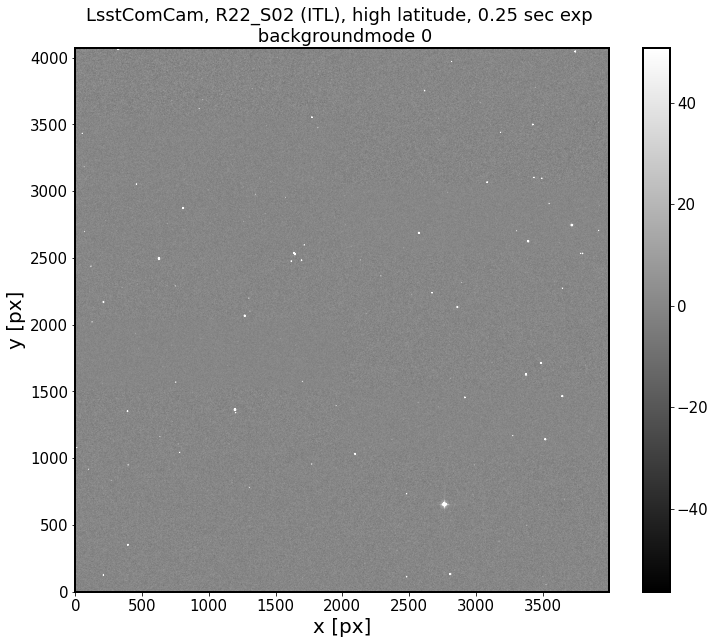

In [98]:
%matplotlib inline

#get the refs for R22_S11
# datasetRefs = list(
#     registry.queryDatasets(
#         datasetType='postISRCCD',
#         instrument='LSSTComCam', # this doesn't have to be specified if butler is started with instrument 
#         collections=['run1'],
#         where="detector.full_name='R22_S11'",
#     )
# )

# get the exposure 
#exposure = butler.getDirect(datasetRefs[0])

# another way to do the same
exposure = butler.get('postISRCCD', detector='R22_S02', instrument="LSSTComCam",
          exposure=4021123106002,collections=['run1'])

data = exposure.image.array
vmin, vmax = zscale.get_limits(data)


fig = plt.figure(figsize=(12, 10))
plt.imshow(data.T, origin='lower', vmin=vmin,vmax=vmax,cmap='gray')
plt.colorbar()
plt.xlabel('x [px]')
plt.ylabel('y [px]')
detector  = exposure.getDetector()
plt.title(f'LsstComCam, {detector.getName()} (ITL), high latitude, 0.25 sec exp \n backgroundmode 0')

In [44]:
# NB:
# In gen2, it was 
# repoRoot = os.path.join(dataRoot, 'rerun/run1') 
# butler = dafPersist.Butler(repoRoot, )
# dataId = dict(run='9006001', visit=4021123106001, raftName='R32', detectorName='S11')
# exposure = butler.get('postISRCCD', **dataId) 
#dataId=dict(detector='R22_S11')


## Repackage and ingest/ISR as Gen3 repo

In [117]:
root_dir = '/project/scichris/aos/ps1_phosim/lsstCam/high/inFocus/raw'

'/project/scichris/aos/ps1_phosim/comcam/med/inFocus'

In [39]:
import os
working_dir =  '/project/scichris/aos/ps1_phosim/'
root_dir = os.path.join(working_dir, 'lsstCam', 'high', 'inFocus')
repackaged_dir = os.path.join(root_dir, 'repackaged')
out_dir =  os.path.join(root_dir, 'raw')
cmd = f"phosim_repackager.py {out_dir} --out_dir {repackaged_dir} --inst lsst"
print(cmd)

phosim_repackager.py /project/scichris/aos/ps1_phosim/lsstCam/high/inFocus/raw --out_dir /project/scichris/aos/ps1_phosim/lsstCam/high/inFocus/repackaged --inst lsst


In [3]:
# repackage the images 
import subprocess
if subprocess.call(cmd, shell=True) != 0:
            raise RuntimeError("Error running: %s" % cmd)

In [90]:
# write yaml file
import yaml
def write_pipeline_yaml(root_dir, instrument='LsstComCam',file_name='testPipeline.yaml'):
    dict_file = {'description':'ISR basic processing pipeline',
                 'instrument':f'lsst.obs.lsst.{instrument}',
                 'tasks':
                     {'isr': 
                          {'class':'lsst.ip.isr.isrTask.IsrTask',
                           'config':
                             {
                              'connections.outputExposure': 'postISRCCD',
                              'doBias':False,
                              'doVariance': False,
                              'doLinearize': False,
                              'doCrosstalk': False,
                              'doDefect': False,
                              'doNanMasking': False,
                              'doInterpolate': False,
                              'doBrighterFatter': False,
                              'doDark': False,
                              'doFlat': False,
                              'doApplyGains': True,
                              'doFringe': False,
                              'doOverscan': True
                              }

                           }
                     }
                 }


    outFile = os.path.join(root_dir, file_name)
    print('Saved as ', outFile)
    with open(outFile, 'w') as file:
        documents = yaml.dump(dict_file, file)
        

def write_isr_script(root_dir, instrument="LsstComCam"):
    '''
    Write to file a script to create butler repo
    and do ISR.
    '''
    outFile = os.path.join(root_dir, 'runIsr.sh')
    
    with open(outFile,'w') as output:
  
        os.chmod(outFile, 0o776) # saves a file with specific permissions - this one needs to be executable
        # by the user and group at least 
        output.write("#!/bin/bash\n")
        output.write("butler create DATA\n")
        output.write(f"butler register-instrument DATA/ lsst.obs.lsst.{instrument}\n")
        output.write("butler ingest-raws DATA repackaged/\n")
        output.write(f"butler define-visits DATA/ lsst.obs.lsst.{instrument}\n")
        output.write(f"butler write-curated-calibrations DATA/ lsst.obs.lsst.{instrument}\n")
        
        if instrument == "LsstComCam":
            instRepo = "LSSTComCam"
        elif instrument == "LsstCam":
            instRepo = "LSSTCam"
            
        output.write(f"pipetask run -j 9 -b DATA/ -i {instRepo}/raw/all,{instRepo}/calib \
        -p testPipeline.yaml --register-dataset-types --output-run run1")
    print(f'Saved as {outFile}')

# write butler script to be executed 
# that creates the repo, registers instrument, ingests raws, defines visits, writes calibs,
# pipetask 

write_pipeline_yaml(root_dir, instrument="LsstComCam")
write_isr_script(root_dir, instrument="LsstComCam")

Saved as  /project/scichris/aos/ps1_phosim/comCam/high/inFocus_rot30/testPipeline.yaml
Saved as /project/scichris/aos/ps1_phosim/comCam/high/inFocus_rot30/runIsr.sh


In [89]:
# Need to make the directory for gen3 repo:
repo_name = 'DATA'
repo_dir = os.path.join(root_dir,repo_name)
if not os.path.exists(repo_dir):
    os.makedirs(repo_dir)

NB: the **entire script**  that creates butler repo, ingests raws, makes calibs, and does ISR, can be run from terminal with  
    
    ./runIsr.sh

NB: need `w_2021_14` or later for `boresight` calculation to be enabled in `obs_lsst` for comcam. Before that is released, need to use `project/scichris/dev/obs_lsst` `master` branch 

## Show comcam defocal images:


Take a look at postISR image:

In [65]:
from lsst.daf import butler as dafButler
import matplotlib.pyplot as plt
from matplotlib import rcParams 
import pandas as pd
import lsst.geom
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

path_to_repo = '/project/scichris/aos/ps1_phosim/comcam/high/extra/DATA/'
butler = dafButler.Butler(path_to_repo)

# registry = butler_lsstCam.registry
# datasetRefs = list(registry.queryDatasets(datasetType='postISRCCD', collections=['run1']))
# for ref in datasetRefs:
#     print(ref.dataId)
#     print(ref.dataId.keys())   
exposure = butler.get('postISRCCD', detector='R22_S11', instrument="LSSTComCam",
          exposure=4021123106002,collections=['run1'])
data = exposure.image.array
vmin, vmax = zscale.get_limits(data)


Text(0.5, 1.0, 'LsstComCam, R22_S11 (ITL), high latitude, 0.25 sec exp \n backgroundmode 0')

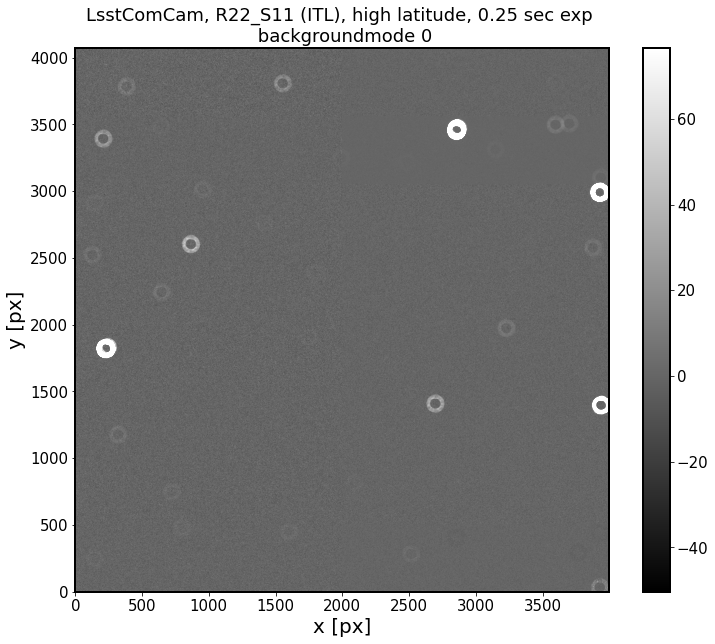

In [66]:
%matplotlib inline
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()


fig = plt.figure(figsize=(12, 10))
plt.imshow(data.T, origin='lower', vmin=vmin,vmax=vmax,cmap='gray')
plt.colorbar()
plt.xlabel('x [px]')
plt.ylabel('y [px]')
detector  = exposure.getDetector()
plt.title(f'LsstComCam, {detector.getName()} (ITL), high latitude, 0.25 sec exp \n backgroundmode 0')

In [48]:
#postIsrExp_lsstCam = butler_lsstCam.get('postISRCCD', dataId=dataId_lsstCam, collections=['run1'])

detectorName 

'R22_S11'

# Show lsstCam  FAM cam images ( full in-focus focal plane & defocal corner sensors ) - coverage test... 

In [70]:
from lsst.daf import butler as dafButler
import matplotlib.pyplot as plt
from matplotlib import rcParams
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()

rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

repo_name = 'DATA2'
repo_dir = os.path.join(root_dir,repo_name)

print(f'Using {repo_dir}')
butler = dafButler.Butler(repo_dir)

# registry = butler_lsstCam.registry
# datasetRefs = list(registry.queryDatasets(datasetType='postISRCCD', collections=['run1']))
# for ref in datasetRefs:
#     print(ref.dataId)
#     print(ref.dataId.keys())   



Using /project/scichris/aos/ps1_phosim/lsstCam/high/inFocus/DATA2


In [ ]:
Plot one of the main rafts (R22_S11),  some other edge raft (R03_S02)

Text(0.5, 1.0, 'LsstCam, R10_S00 (ITL), high latitude, 0.25 sec exp \n quickbackground')

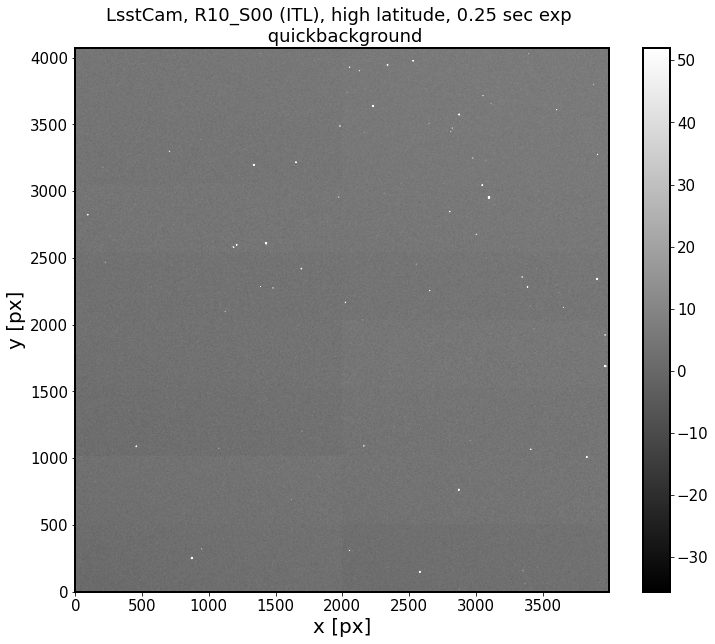

In [74]:
%matplotlib inline

exposure = butler.get('postISRCCD', detector='R10_S00', instrument="LSSTCam",
          exposure=4021123106002,collections=['run3'])
data = exposure.image.array
vmin, vmax = zscale.get_limits(data)

fig = plt.figure(figsize=(12, 10))
plt.imshow(data.T, origin='lower', vmin=vmin,vmax=vmax,cmap='gray')
plt.colorbar()
plt.xlabel('x [px]')
plt.ylabel('y [px]')
detector  = exposure.getDetector()
plt.title(f'LsstCam, {detector.getName()} (ITL), high latitude, 0.25 sec exp \n quickbackground')

--> why am I seeing some backgorund issues in the postISR image?  

--> they were not there with `backgroundmode 0`, but appear with `quickbackground` 

--> check the header bias values .... (calibs were made now with `2021_14`, i.e. obs_lsst master ,  whereas the simulations with whatever I put into `phosim_syseng4/data/lsst`... 

In [67]:
# in the header - shows what phosim had used : 
from astropy.io import fits
hdul = fits.open(os.path.join(root_dir,'repackaged', 'MC_H_20211231_006002_R10_S00.fits'))

for key in ['AMPID','GAIN','BIAS']:
    print(f'{key}: {hdul[1].header[key]}')


AMPID: C10
GAIN: 1.37014
BIAS: 997.044


In [68]:
# in obs_lsst   lsstCam mapper from where calibs were made : 
from lsst.obs.lsst import LsstCam
camera = LsstCam().getCamera()
detector = camera['R10_S00']
amp = detector['C10']
print(amp.getGain())


1.37014


--> Need to figure out why these values are different , and ensure which versions of `obs_lsst`, `phosim_syseng4` were used to create these. Would be good to record that in the script. 

Testing which weekly this was made with on `lsst-devl03` : 


ssh lsst-devl03

source "/software/lsstsw/stack/loadLSST.bash"
setup lsst_distrib 

eups list obs_lsst

cd /project/scichris/dev/



--> Try simulating single star, compare ISR for images with and without background

--> Copied locations of comcam arrows and removed all but first 11 stars: 
    
    cp /project/scichris/aos/images/lsstCam/starExtra.inst  /project/scichris/aos/ps1_phosim/testBkgnd/
    
--> Run phosim without background for LsstCam  R22 : 

    python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/ps1_phosim/testBkgnd/starSingle.inst -i lsst -e 1 -c /project/scichris/aos/ps1_phosim/noBkgnd.cmd -p 25 -o /project/scichris/aos/ps1_phosim/testBkgnd/noBkgnd/ > starPhoSim.log 2>&1
    
--> Run phosim with quick background for LsstCam  R22 : 

    python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/ps1_phosim/testBkgnd/starSingle.inst -i lsst -e 1 -c /project/scichris/aos/ps1_phosim/qckBkgnd.cmd -p 25 -o /project/scichris/aos/ps1_phosim/testBkgnd/qckBkgnd/ > starPhoSim.log 2>&1
    
    
--> Repackage 

    phosim_repackager.py /project/scichris/aos/ps1_phosim/testBkgnd/noBkgnd/ --out_dir /project/scichris/aos/ps1_phosim/testBkgnd/noBkgnd/repackaged/ --inst lsst
    
    phosim_repackager.py /project/scichris/aos/ps1_phosim/testBkgnd/qckBkgnd/ --out_dir /project/scichris/aos/ps1_phosim/testBkgnd/qckBkgnd/repackaged/ --inst lsst
    
    
    phosim_repackager.py /project/scichris/aos/ps1_phosim/testBkgnd/qckBkgnd/ --out_dir /project/scichris/aos/ps1_phosim/testBkgnd/qckBkgnd/repackaged_T/ --inst lsst

Show:

Using /project/scichris/aos/ps1_phosim/testBkgnd/noBkgnd/DATA
-17.874466 29.086128


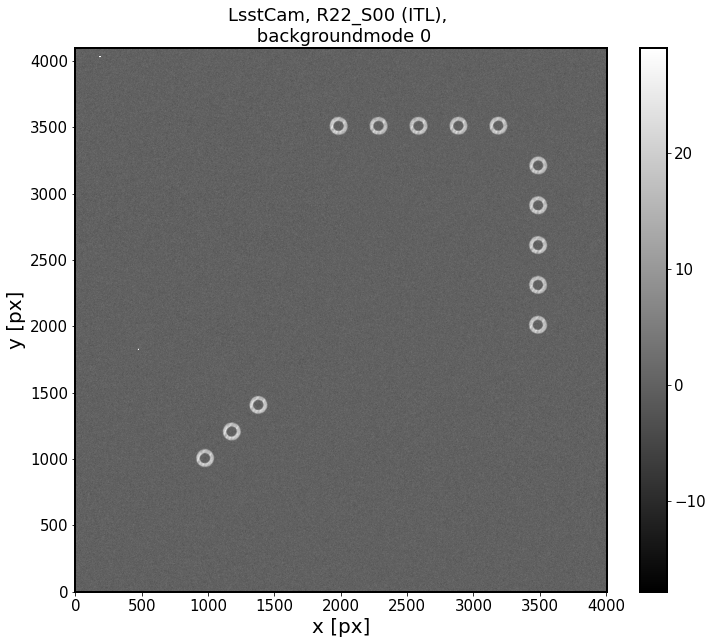

In [40]:
repo_name = 'DATA'
repo_dir = os.path.join('/project/scichris/aos/ps1_phosim/testBkgnd/noBkgnd/',repo_name)

print(f'Using {repo_dir}')
butler = dafButler.Butler(repo_dir)

%matplotlib inline

exposure = butler.get('postISRCCD', detector='R22_S00', instrument="LSSTCam",
          exposure=4000021706001,collections=['run1'])
data = exposure.image.array
vmin, vmax = zscale.get_limits(data)
print(vmin,vmax)

fig = plt.figure(figsize=(12, 10))
plt.imshow(data.T, origin='lower', vmin=vmin,vmax=vmax,cmap='gray')
plt.colorbar()
plt.xlabel('x [px]')
plt.ylabel('y [px]')
detector  = exposure.getDetector()
plt.title(f'LsstCam, {detector.getName()} (ITL), \n backgroundmode 0')
plt.savefig('/project/scichris/aos/ps1_phosim/testBkgnd/noBkgnd/postISR_R22_S00_noBkgnd.png',
           bbox_inches='tight')

-17.874466 29.086128


Using /project/scichris/aos/ps1_phosim/testBkgnd/qckBkgnd/DATA
-7.9662666 60.39493


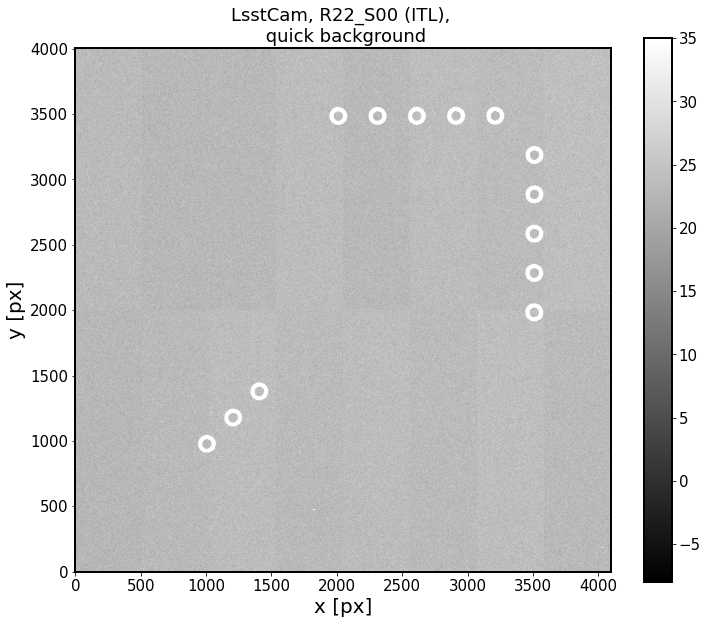

In [41]:
from lsst.daf import butler as dafButler
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import rcParams
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()

rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18


repo_name = 'DATA'
repo_dir = os.path.join('/project/scichris/aos/ps1_phosim/testBkgnd/qckBkgnd/',repo_name)

print(f'Using {repo_dir}')
butler = dafButler.Butler(repo_dir)

%matplotlib inline

exposure = butler.get('postISRCCD', detector='R22_S00', instrument="LSSTCam",
          exposure=4000021706001,collections=['run1'])
data = exposure.image.array
vmin, vmax = zscale.get_limits(data)
print(vmin,vmax)
fig = plt.figure(figsize=(12, 10))
plt.imshow(data, origin='lower', cmap='gray', vmin=vmin,vmax=35,)
plt.colorbar()
plt.xlabel('x [px]')
plt.ylabel('y [px]')
detector  = exposure.getDetector()
plt.title(f'LsstCam, {detector.getName()} (ITL), \n quick background')
plt.savefig('/project/scichris/aos/ps1_phosim/testBkgnd/qckBkgnd/postISR_R22_S00_qckBkgnd.png',
           bbox_inches='tight')

In [14]:
fpath = os.path.join(repo_dir,'run1', 'postISRCCD','20000217','MC_H_20000217_006001')
fname = os.listdir(fpath)[0]
file_path = os.path.join(fpath,fname)

In [33]:
repo_dir

'/project/scichris/aos/ps1_phosim/testBkgnd/qckBkgnd/DATA'

In [16]:
from astropy.io import fits
hdul=fits.open(file_path)

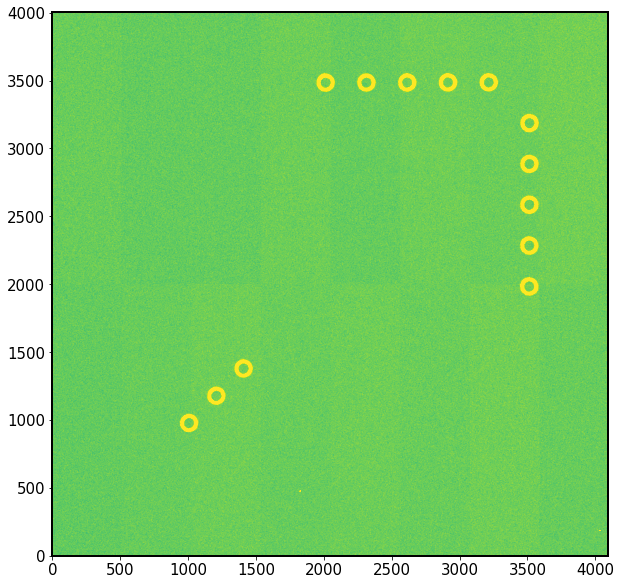

In [36]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(hdul[1].data,vmax=35, origin='lower')

(array([1.6400382e+07, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 2.0000000e+00]),
 array([-1.5940947e+01,  2.4159939e+03,  4.8479287e+03,  7.2798638e+03,
         9.7117988e+03,  1.2143733e+04,  1.4575669e+04,  1.7007604e+04,
         1.9439539e+04,  2.1871473e+04,  2.4303408e+04], dtype=float32),
 <BarContainer object of 10 artists>)

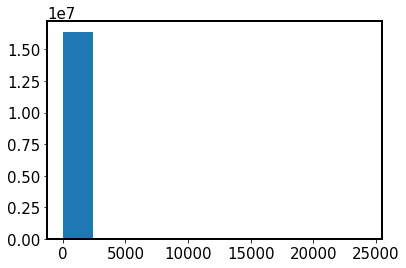

In [28]:
plt.hist(np.ravel(hdul[1].data))

Find out whether repackaging and ingesting into gen2 repo with old way would have dealt properly with this background:
    
    mkdir input
    mkdir fake_flat
    cd fake_flat
    makeGainImages.py --detector_list R22_S00
    
    echo "lsst.obs.lsst.lsstCamMapper.LsstCamMapper" > _mapper
    
    ingestImages.py /project/scichris/aos/ps1_phosim/testBkgnd/qckBkgnd/input/ /project/scichris/aos/ps1_phosim/testBkgnd/qckBkgnd/repackaged/MC_*.fits
    
    
    ingestCalibs.py /project/scichris/aos/ps1_phosim/testBkgnd/qckBkgnd/input/ /project/scichris/aos/ps1_phosim/testBkgnd/qckBkgnd/input/fake_flat/R22_S00_g.fits --validity 99999 --output /project/scichris/aos/ps1_phosim/testBkgnd/qckBkgnd/input/
    
    
put into `isr_config.py` :     

    config.isr.doBias=False
    config.isr.doDark=False
    config.isr.doFlat=True
    config.isr.doFringe=False
    config.isr.doDefect=False
    config.isr.doOverscan=True
    config.isr.doCrosstalk=False


    runIsr.py  /project/scichris/aos/ps1_phosim/testBkgnd/qckBkgnd/input/    --id  --rerun=run1  --configfile /project/scichris/aos/ps1_phosim/testBkgnd/qckBkgnd/input/isr_config.py  --no-versions
    
    
check it out 

-8.127866 62.85398


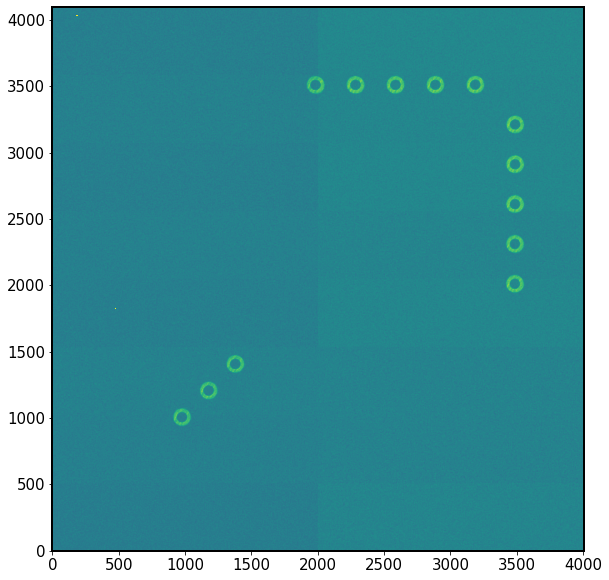

In [87]:
# gen2 repo
import lsst.daf.persistence as dafPersist

dataRoot='/project/scichris/aos/ps1_phosim/testBkgnd/qckBkgnd/input/'
repoRoot = os.path.join(dataRoot, 'rerun/run1') 
butler = dafPersist.Butler(repoRoot, )
dataId = dict(run='9006001', visit=4000021706001, raftName='R22', detectorName='S00')
exposure = butler.get('postISRCCD', **dataId) 
data = exposure.image.array
vmin, vmax = zscale.get_limits(data)
print(vmin,vmax)

fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(data.T, origin='lower',vmax=vmax, vmin=vmin)#vmax=2600)




again, the ISR is incorrect  - what's going on ? I've made these with `Opsim_filter 1 `, i.e. `g` , and that's why I used `g` calibs. And I run `quickbackground`...

I tried not-transposing the calibs .. 

-7.966266 60.39493


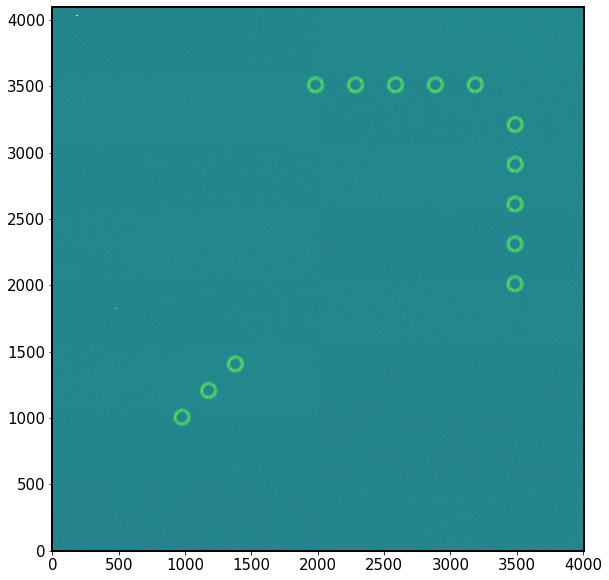

In [88]:
# gen2 repo
import lsst.daf.persistence as dafPersist

dataRoot='/project/scichris/aos/ps1_phosim/testBkgnd/qckBkgnd/input2/'
repoRoot = os.path.join(dataRoot, 'rerun/run1') 
butler = dafPersist.Butler(repoRoot, )
dataId = dict(run='9006001', visit=4000021706001, raftName='R22', detectorName='S00')
exposure = butler.get('postISRCCD', **dataId) 
data = exposure.image.array
vmin, vmax = zscale.get_limits(data)
print(vmin,vmax)
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(data.T, origin='lower',vmax=vmax, vmin=vmin)#vmax=2600)




There's still some issues, but slightly less... 

I wonder if then the fact that phosim images are rotated wrt obs_lsst matters, and we didn't see that problem before because of using quick background? 

Why is it that it's not visible with `backgroundmode 0` ? ? ? 

## Compare the WCS information to the input catalog

In [67]:
root_dir = '/project/scichris/aos/ps1_phosim/lsstCam/high/inFocus/'

repo_name = 'DATA'
repo_dir = os.path.join(root_dir,repo_name)

print(f'Using {repo_dir}')
butler = dafButler.Butler(repo_dir)

exposure = butler.get('postISRCCD', detector='R03_S02', instrument="LSSTCam",
          exposure=4021123106002,collections=['run1'])

Using /project/scichris/aos/ps1_phosim/lsstCam/high/inFocus/DATA


In [68]:
test_cat = np.genfromtxt('/project/scichris/aos/ps1_phosim/stars_lsstCam_PS1_high_inFocus.inst',
                        skip_header=16)

In [69]:
test_cat_df = pd.DataFrame(test_cat[:, 1:5], columns=['id', 'ra', 'dec', 'g'])

In [49]:
test_cat_df

id          ra        dec          g
0       1.343719e+17  194.720633  21.974847  18.000299
1       1.349519e+17  194.720664  22.461810  21.397400
2       1.395919e+17  194.720667  26.326815  21.489700
3       1.367719e+17  194.720699  23.980403  19.775200
4       1.342119e+17  194.720720  21.844772  21.198400
...              ...         ...        ...        ...
223970  1.343120e+17  200.208165  21.929294  20.578199
223971  1.368120e+17  200.208173  24.015972  20.107300
223972  1.370720e+17  200.208177  24.225243  20.934200
223973  1.370720e+17  200.208190  24.227799  21.334000
223974  1.361920e+17  200.208203  23.496994  19.260900

[223975 rows x 4 columns]

In [70]:
wcs = exposure.getWcs()

x_pix_list = []
y_pix_list = []


for i in range(len(test_cat_df)):
    x_pix, y_pix = wcs.skyToPixel(
        lsst.geom.SpherePoint(
            test_cat_df.iloc[i]['ra'], test_cat_df.iloc[i]['dec'], lsst.geom.degrees
        )
    )
    x_pix_list.append(x_pix)
    y_pix_list.append(y_pix)
    
    

(0.0, 4000.0)

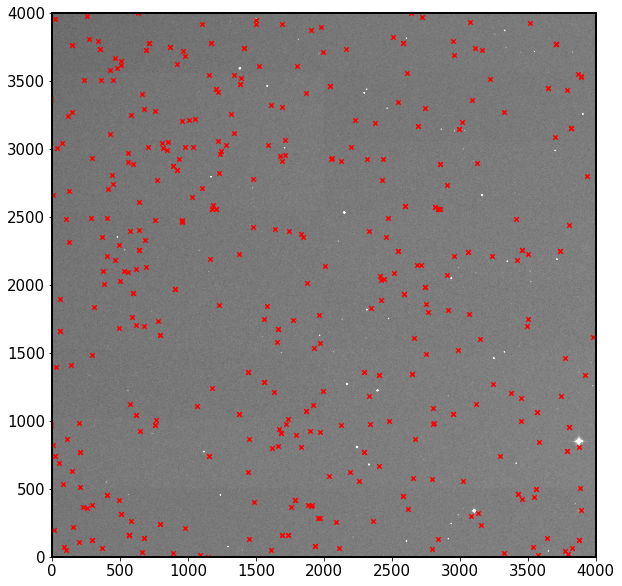

In [58]:
%matplotlib inline
fig = plt.figure(figsize=(10,10))
data = exposure.image.array
vmin, vmax = zscale.get_limits(data)

plt.imshow(data.T, origin='lower', vmin=vmin,vmax=vmax,cmap='gray')
plt.scatter(x_pix_list, y_pix_list, c='r', marker='x', s=20)
plt.xlim(0, 4000)
plt.ylim(0, 4000)

In [71]:
postIsr_md = exposure.getMetadata()
postIsr_visit_info = postIsr_md.keys()
postIsr_md['RA_DEG'], postIsr_md['DEC_DEG'], postIsr_md['ROTANG']

(197.464413, 24.335542, 0.0)

In [72]:
from lsst.obs.base import (bboxFromIraf, MakeRawVisitInfoViaObsInfo, 
createInitialSkyWcs, createInitialSkyWcsFromBoresight)

In [73]:
pointing_loc = lsst.geom.SpherePoint(postIsr_md['RA_DEG'], postIsr_md['DEC_DEG'], lsst.geom.degrees)

In [80]:
new_wcs = createInitialSkyWcsFromBoresight(pointing_loc, 
                                           (postIsr_md['ROTANG']+90)*lsst.geom.degrees,
                                           exposure.getDetector(),
                                           flipX=False)

In [81]:
new_x_pix_list = []
new_y_pix_list = []

for i in range(len(test_cat_df)):
    x_pix, y_pix = new_wcs.skyToPixel(
        lsst.geom.SpherePoint(
            test_cat_df.iloc[i]['ra'], test_cat_df.iloc[i]['dec'], lsst.geom.degrees
        )
    )
    new_x_pix_list.append(x_pix)
    new_y_pix_list.append(y_pix)
    


Text(0, 0.5, 'y [px]')

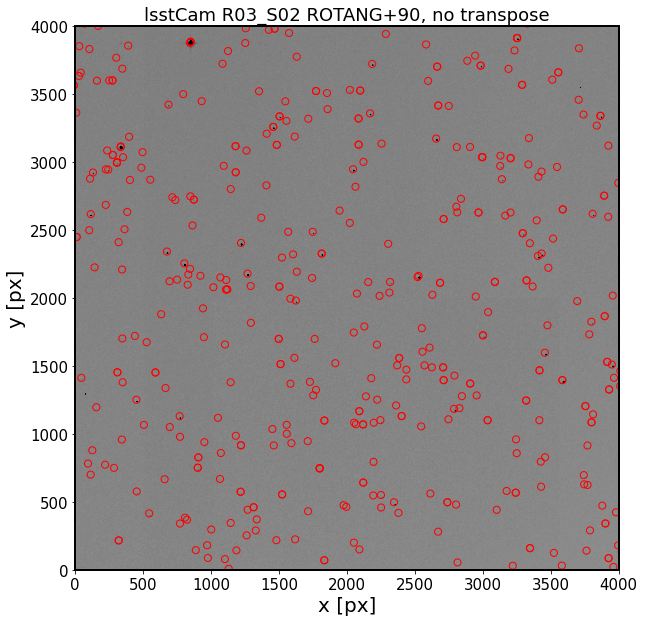

In [82]:
fig = plt.figure(figsize=(10,10))
plt.imshow(exposure.image.array, vmin=vmin,vmax=vmax,cmap='Greys')
plt.scatter(new_x_pix_list, new_y_pix_list,  facecolors='none', edgecolors='r', marker='o',s=50, )
plt.xlim(0, 4000)
plt.ylim(0, 4000)
plt.title(f"lsstCam {exposure.getDetector().getName()} ROTANG+90, no transpose")
plt.xlabel('x [px]')
plt.ylabel('y [px]')

## Use ComCam high in-focus with `rotSkyPos` set to `30.0` rather than `0.0` : 

    python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/ps1_phosim/stars_comcam_PS1_high_rot30.inst -i comcam -e 1 -c /project/scichris/aos/ps1_phosim/noBkgnd.cmd -p 25 -o /project/scichris/aos/ps1_phosim/comCam/high/inFocus_rot30/raw > /project/scichris/aos/ps1_phosim/comCam/high/inFocus_rot30/raw/starPhoSim.log 2>&1
    
    
    phosim_repackager.py /project/scichris/aos/ps1_phosim/comCam/high/inFocus_rot30/raw --out_dir /project/scichris/aos/ps1_phosim/comCam/high/inFocus_rot30/repackaged --inst comcam

In [83]:
import os
from lsst.daf import butler as dafButler
import matplotlib.pyplot as plt
from matplotlib import rcParams 
import pandas as pd
import lsst.geom


root_dir = '/project/scichris/aos/ps1_phosim/comCam/high/inFocus_rot30/'

repo_name = 'DATA'
repo_dir = os.path.join(root_dir,repo_name)

print(f'Using {repo_dir}')
butler = dafButler.Butler(repo_dir)

exposure = butler.get('postISRCCD', detector='R22_S12', instrument="LSSTComCam",
          exposure=4021123106002,collections=['run1'])



Using /project/scichris/aos/ps1_phosim/comCam/high/inFocus_rot30/DATA


In [84]:
import numpy as np 
test_cat = np.genfromtxt('/project/scichris/aos/ps1_phosim/stars_comcam_PS1_high_rot30.inst',
                        skip_header=16)

test_cat_df = pd.DataFrame(test_cat[:, 1:5], columns=['id', 'ra', 'dec', 'g'])

postIsr_md = exposure.getMetadata()
postIsr_visit_info = postIsr_md.keys()
postIsr_md['RA_DEG'], postIsr_md['DEC_DEG'], postIsr_md['ROTANG']

(197.464413, 24.335542, 30.0)

In [51]:
test_cat_df

id          ra        dec          g
0     1.375620e+17  197.025884  24.635424  21.355101
1     1.375620e+17  197.025884  24.635424  21.355101
2     1.368020e+17  197.026267  24.007597  21.418100
3     1.369820e+17  197.026503  24.150414  19.897301
4     1.369820e+17  197.026503  24.150414  19.897301
...            ...         ...        ...        ...
5536  1.375120e+17  197.901904  24.593945  21.416401
5537  1.375020e+17  197.901938  24.590028  19.735800
5538  1.369020e+17  197.902669  24.086342  20.997200
5539  1.374620e+17  197.902698  24.554827  21.481300
5540  1.375820e+17  197.903021  24.654679  21.391899

[5541 rows x 4 columns]

In [95]:
from lsst.obs.base import (bboxFromIraf, MakeRawVisitInfoViaObsInfo, 
createInitialSkyWcs, createInitialSkyWcsFromBoresight)

pointing_loc = lsst.geom.SpherePoint(postIsr_md['RA_DEG'], postIsr_md['DEC_DEG'], lsst.geom.degrees)
new_wcs = createInitialSkyWcsFromBoresight(pointing_loc, 
                                           (postIsr_md['ROTANG']+90)*lsst.geom.degrees,
                                           exposure.getDetector(),
                                           flipX=False)

In [96]:
new_x_pix_list = []
new_y_pix_list = []

for i in range(len(test_cat_df)):
    x_pix, y_pix = new_wcs.skyToPixel(
        lsst.geom.SpherePoint(
            test_cat_df.iloc[i]['ra'], test_cat_df.iloc[i]['dec'], lsst.geom.degrees
        )
    )
    new_x_pix_list.append(x_pix)
    new_y_pix_list.append(y_pix)
    


In [97]:
#new_x_pix_list

Text(0, 0.5, 'y [px]')

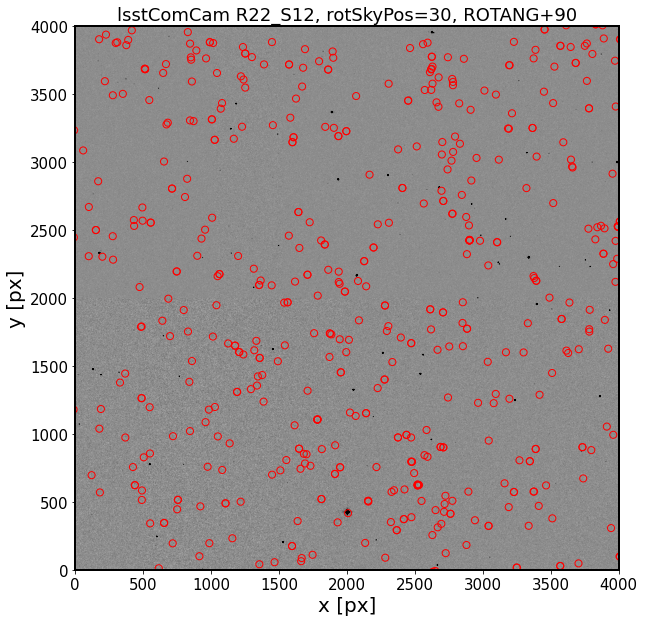

In [98]:
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()

rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

data = exposure.image.array
vmin, vmax = zscale.get_limits(data)

fig = plt.figure(figsize=(10,10))
plt.imshow(exposure.image.array, vmin=vmin,vmax=vmax,cmap='Greys')
plt.scatter(new_x_pix_list, new_y_pix_list,  facecolors='none', edgecolors='r', marker='o',s=50, )
plt.xlim(0, 4000)
plt.ylim(0, 4000)
plt.title(f"lsstComCam {exposure.getDetector().getName()}, rotSkyPos=30, ROTANG+90")
plt.xlabel('x [px]')
plt.ylabel('y [px]')

## Use ComCam high in-focus with `rotTelPos` set to `30.0` rather than `0.0` : does it matter?  

    python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/ps1_phosim/stars_comcam_PS1_high_rotTelPos30.inst -i comcam -e 1 -c /project/scichris/aos/ps1_phosim/noBkgnd.cmd -p 25 -o /project/scichris/aos/ps1_phosim/comCam/high/inFocus_rotTelPos30/raw > /project/scichris/aos/ps1_phosim/comCam/high/inFocus_rotTelPos30/raw/starPhoSim.log 2>&1
    
    
    phosim_repackager.py /project/scichris/aos/ps1_phosim/comCam/high/inFocus_rotTelPos30/raw --out_dir /project/scichris/aos/ps1_phosim/comCam/high/inFocus_rotTelPos30/repackaged --inst comcam
    
    
    

Using /project/scichris/aos/ps1_phosim/comCam/high/inFocus_rotTelPos30/DATA
197.464413 24.335542 0.0


Text(0, 0.5, 'y [px]')

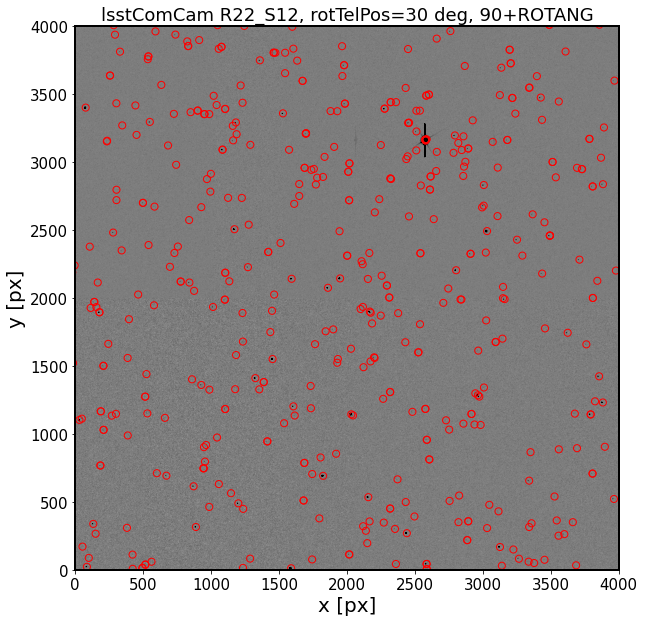

In [106]:
import os
import numpy as np 
from lsst.daf import butler as dafButler
import matplotlib.pyplot as plt
from matplotlib import rcParams 
import pandas as pd
import lsst.geom
from lsst.obs.base import (bboxFromIraf, MakeRawVisitInfoViaObsInfo, 
createInitialSkyWcs, createInitialSkyWcsFromBoresight)
from astropy.visualization import ZScaleInterval
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18


# read the butler repo 
root_dir = '/project/scichris/aos/ps1_phosim/comCam/high/inFocus_rotTelPos30/'
repo_name = 'DATA'
repo_dir = os.path.join(root_dir,repo_name)

print(f'Using {repo_dir}')
butler = dafButler.Butler(repo_dir)

exposure = butler.get('postISRCCD', detector='R22_S12', instrument="LSSTComCam",
          exposure=4021123106002,collections=['run1'])



# read the instance catalog used to create phosim simulation 
test_cat = np.genfromtxt('/project/scichris/aos/ps1_phosim/stars_comcam_PS1_high_rotTelPos30.inst',
                        skip_header=16)

test_cat_df = pd.DataFrame(test_cat[:, 1:5], columns=['id', 'ra', 'dec', 'g'])

postIsr_md = exposure.getMetadata()
postIsr_visit_info = postIsr_md.keys()
print(postIsr_md['RA_DEG'], postIsr_md['DEC_DEG'], postIsr_md['ROTANG'])



# create the new WCS 
pointing_loc = lsst.geom.SpherePoint(postIsr_md['RA_DEG'], postIsr_md['DEC_DEG'], lsst.geom.degrees)
new_wcs = createInitialSkyWcsFromBoresight(pointing_loc, 
                                           (90+postIsr_md['ROTANG'])*lsst.geom.degrees,
                                           exposure.getDetector(),
                                           flipX=False)

# calculate the x,y positions of stars given the input catalog and the WCS 
new_x_pix_list = []
new_y_pix_list = []

for i in range(len(test_cat_df)):
    x_pix, y_pix = new_wcs.skyToPixel(
        lsst.geom.SpherePoint(
            test_cat_df.iloc[i]['ra'], test_cat_df.iloc[i]['dec'], lsst.geom.degrees
        )
    )
    new_x_pix_list.append(x_pix)
    new_y_pix_list.append(y_pix)
    

# plot the location of catalog stars atop the postISR exposure 
zscale = ZScaleInterval()
data = exposure.image.array
vmin, vmax = zscale.get_limits(data)

fig = plt.figure(figsize=(10,10))
plt.imshow(exposure.image.array, vmin=vmin,vmax=vmax,cmap='Greys')
plt.scatter(new_x_pix_list, new_y_pix_list,  facecolors='none', edgecolors='r', marker='o',s=50, )
plt.xlim(0, 4000)
plt.ylim(0, 4000)
plt.title(f"lsstComCam {exposure.getDetector().getName()}, rotTelPos=30 deg, 90+ROTANG")
plt.xlabel('x [px]')
plt.ylabel('y [px]')

## LsstCam: Simulate the directional arrows to find out whether transpose is needed ... 

    mkdir /project/scichris/aos/ps1_phosim/testArrow
    cp /project/scichris/aos/ps1_phosim/testBkgnd/starSingle.inst  /project/scichris/aos/ps1_phosim/testArrow/
    
    # added a star to a lower location in the catalog... 
   

In [2]:
# show that catalog 
import numpy as np 
import pandas as pd

test_cat = np.genfromtxt('/project/scichris/aos/ps1_phosim/testArrow/starSingle.inst',
                        skip_header=16)
test_cat_df = pd.DataFrame(test_cat[:, 1:5], 
                           columns=['id', 'ra', 'dec', 'g'])


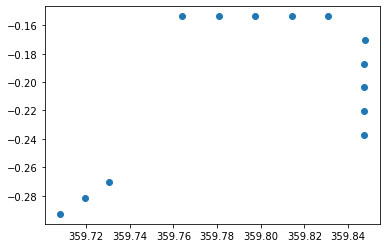

In [5]:
import matplotlib.pyplot as plt 
plt.scatter(test_cat_df['ra'],test_cat_df['dec'])

I added a star in the lower-right:

Text(0, 0.5, 'dec')

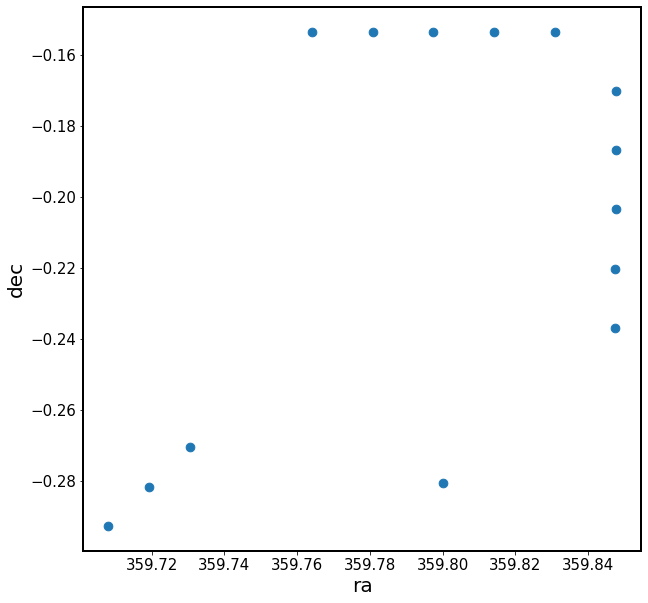

In [21]:
import matplotlib.pyplot as plt 
test_cat = np.genfromtxt('/project/scichris/aos/ps1_phosim/testArrow/starSingle.inst',
                        skip_header=16)
test_cat_df = pd.DataFrame(test_cat[:, 1:5], 
                           columns=['id', 'ra', 'dec', 'g'])
fig = plt.figure(figsize=(10,10))
plt.scatter(test_cat_df['ra'], test_cat_df['dec'], s=75)
plt.xlabel('ra')
plt.ylabel('dec')

Now run this catalog with phosim: 

    
    ssh scichris@lsst-login01.ncsa.illinois.edu 
    ssh lsst-devl03

    source "/software/lsstsw/stack/loadLSST.bash"
    setup lsst_distrib 
    
    python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/ps1_phosim/testArrow/starSingle.inst -i lsst -e 1 -c /project/scichris/aos/ps1_phosim/noBkgnd.cmd -p 25 -o /project/scichris/aos/ps1_phosim/testArrow/lsstCam/raw/ > starPhoSim.log 2>&1


    phosim_repackager.py /project/scichris/aos/ps1_phosim/testArrow/lsstCam/raw/ --out_dir /project/scichris/aos/ps1_phosim/testArrow/lsstCam/repackaged --inst lsst
    
    

Ingest into a gen3 repo:
    
    cp /project/scichris/aos/ps1_phosim/lsstCam/high/inFocus/runIsr.sh . 
    cp /project/scichris/aos/ps1_phosim/lsstCam/high/inFocus/testPipeline.yaml .
    
    ./runIsr.sh 
    
    

Show the postISR :

Using /project/scichris/aos/ps1_phosim/testArrow/lsstCam/DATA
0.0 0.0 0.0


Text(0, 0.5, 'y [px]')

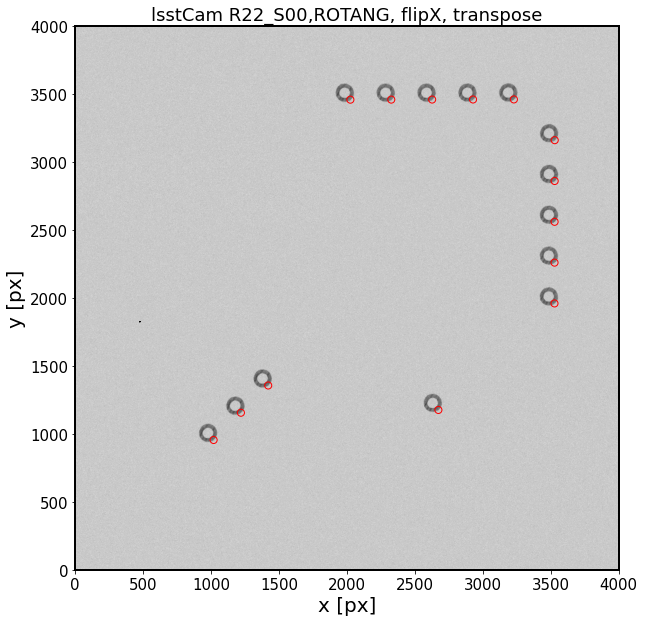

In [39]:
import os
import numpy as np 
from lsst.daf import butler as dafButler
import matplotlib.pyplot as plt
from matplotlib import rcParams 
import pandas as pd
import lsst.geom
from lsst.obs.base import (bboxFromIraf, MakeRawVisitInfoViaObsInfo, 
createInitialSkyWcs, createInitialSkyWcsFromBoresight)
from astropy.visualization import ZScaleInterval
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18


# read the butler repo 
root_dir = '/project/scichris/aos/ps1_phosim/testArrow/lsstCam/'
repo_name = 'DATA'
repo_dir = os.path.join(root_dir,repo_name)

print(f'Using {repo_dir}')
butler = dafButler.Butler(repo_dir)
instrument = "LSSTCam"
dataId0 = dict(instrument=instrument)
dataset = next(iter(
                    butler.registry.queryDatasets(
                        datasetType='postISRCCD', 
                        collections=['run1'],
                        dataId=dataId0  )
                    )
               )

exposure = butler.get('postISRCCD', detector='R22_S00', instrument="LSSTCam",
          exposure=dataset.dataId["exposure"],collections=['run1'])



# read the instance catalog used to create phosim simulation 
test_cat = np.genfromtxt('/project/scichris/aos/ps1_phosim/testArrow/starSingle.inst',
                        skip_header=16)

test_cat_df = pd.DataFrame(test_cat[:, 1:5], columns=['id', 'ra', 'dec', 'g'])

postIsr_md = exposure.getMetadata()
postIsr_visit_info = postIsr_md.keys()
print(postIsr_md['RA_DEG'], postIsr_md['DEC_DEG'], postIsr_md['ROTANG'])


# create the new WCS 
pointing_loc = lsst.geom.SpherePoint(postIsr_md['RA_DEG'], postIsr_md['DEC_DEG'], lsst.geom.degrees)
new_wcs = createInitialSkyWcsFromBoresight(pointing_loc, 
                                           (postIsr_md['ROTANG'])*lsst.geom.degrees,
                                           exposure.getDetector(),
                                           flipX=True,)

# calculate the x,y positions of stars given the input catalog and the WCS 
new_x_pix_list = []
new_y_pix_list = []

for i in range(len(test_cat_df)):
    x_pix, y_pix = new_wcs.skyToPixel(
        lsst.geom.SpherePoint(
            test_cat_df.iloc[i]['ra'], test_cat_df.iloc[i]['dec'], lsst.geom.degrees
        )
    )
    new_x_pix_list.append(x_pix)
    new_y_pix_list.append(y_pix)
    

# plot the location of catalog stars atop the postISR exposure 
zscale = ZScaleInterval()
data = exposure.image.array
vmin, vmax = zscale.get_limits(data)

fig = plt.figure(figsize=(10,10))
plt.imshow(exposure.image.array.T, vmin=vmin,vmax=vmax,cmap='Greys')
plt.scatter(new_x_pix_list, new_y_pix_list,  facecolors='none', edgecolors='r', marker='o',s=50, )
plt.xlim(0, 4000)
plt.ylim(0, 4000)
plt.title(f"lsstCam {exposure.getDetector().getName()},ROTANG, flipX, transpose")
plt.xlabel('x [px]')
plt.ylabel('y [px]')

Show that with `cameraGeomUtils` : 

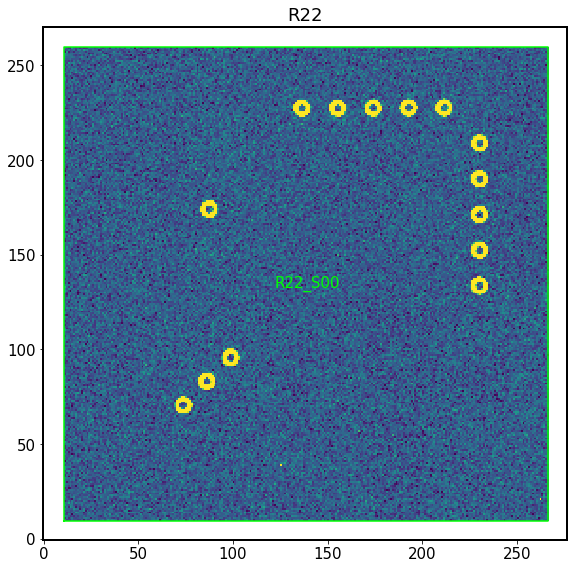

In [51]:
from lsst.daf import butler as dafButler
import lsst.afw.cameraGeom.utils as cameraGeomUtils
import lsst.afw.display as afwDisplay
import matplotlib.pyplot as plt
from matplotlib import rcParams 
from astropy.io import fits
import numpy as np 
import os 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

afwDisplay.setDefaultBackend("matplotlib")

repo_dir = os.path.join('/project/scichris/aos/ps1_phosim/testArrow/lsstCam/DATA/')

# need to specify the calib collections to be able to access the camera 
instrument = 'LSSTCam'
butler = dafButler.Butler(repo_dir, collections=[f'{instrument}/raw/all',
                                                 f'{instrument}/calib','run1',
                                                 f'{instrument}/calib/unbounded']
                         )

dataId0 = dict(instrument=instrument)
dataset = next(iter(
                    butler.registry.queryDatasets(
                        datasetType='postISRCCD', 
                        collections=['run1'],
                        dataId=dataId0  )
                    )
               )

exposure = dataset.dataId["exposure"]

camera  = butler.get("camera", instrument=instrument, exposure=exposure)


fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.2, wspace=0.0, )

disp = afwDisplay.Display(fig)
disp.scale('asinh', 'zscale', Q=1)

disp.setImageColormap('viridis' if True else 'gray')
dataType = "postISRCCD"

detectorNameList = ['R22_S00'] 
                
i = 1
#for detectorNameList in detectorNameLists:
    
ax = fig.add_subplot(1, 1, i)

raftName = detectorNameList[0][:3]
mos = cameraGeomUtils.showCamera(camera,
                             cameraGeomUtils.ButlerImage(butler, dataType, 
                                                         instrument=instrument, 
                                                         exposure=exposure,
                                                         verbose=True),
                             binSize=16, 
                             detectorNameList=detectorNameList, 
                             display=disp, overlay=True,
                             title=raftName,)
disp.show_colorbar(False)
#ax.axis("off")

i += 1 

In [52]:
cameraGeomUtils.showCamera?

Signature:
cameraGeomUtils.showCamera(
    camera,
    imageSource=<lsst.afw.cameraGeom.utils.FakeImageDataSource object at 0x7fbf39af97f0>,
    imageFactory=<class 'lsst.afw.image.image.ImageF'>,
    detectorNameList=None,
    binSize=10,
    bufferSize=10,
    overlay=True,
    title='',
    showWcs=None,
    ctype='green',
    textSize=1.25,
    originAtCenter=True,
    display=None,
    **kwargs,
)
Docstring:
Show a Camera on display, with the specified display.

The rotation of the sensors is snapped to the nearest multiple of 90 deg.
Also note that the pixel size is constant over the image array. The lower
left corner (LLC) of each sensor amp is snapped to the LLC of the pixel
containing the LLC of the image.

Parameters
----------
camera : `lsst.afw.cameraGeom.Camera`
    Camera object to use to make the image.
imageSource : `FakeImageDataSource` or `None`
    Source to get ccd images.  Must have a ``getCcdImage()`` method.
imageFactory : `lsst.afw.image.Image`
    Type of image

## LsstCam, single arrow: try using rotSkyPos = 30 

    python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/ps1_phosim/testArrow/starSingle_rotTelPos.inst -i lsst -e 1 -c /project/scichris/aos/ps1_phosim/noBkgnd.cmd -p 25 -o /project/scichris/aos/ps1_phosim/testArrow/lsstCam_rotTelPos/raw/ > starPhoSim.log 2>&1


    phosim_repackager.py /project/scichris/aos/ps1_phosim/testArrow/lsstCam_rotSkyPos/raw/ --out_dir /project/scichris/aos/ps1_phosim/testArrow/lsstCam_rotSkyPos/repackaged --inst lsst
    
    

doing `rotSkyPos` rotates the whole sky (presumably around R22 S11, i.e. the center of the focal plane... )

In [ ]:
So what used to be R22_S00, is now spread along R12_S21, R22_S00, and R22_S01 

Using /project/scichris/aos/ps1_phosim/testArrow/lsstCam_rotSkyPos/DATA
0.0 0.0 30.0


Text(0, 0.5, 'y [px]')

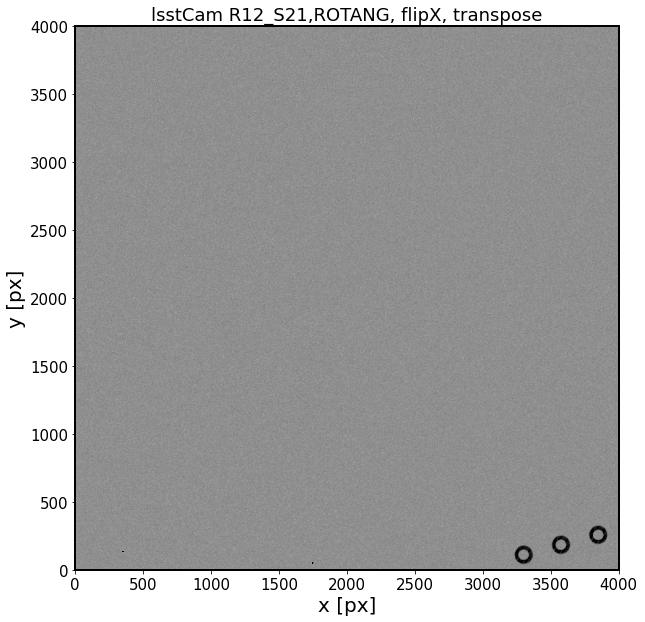

In [49]:
import os
import numpy as np 
from lsst.daf import butler as dafButler
import matplotlib.pyplot as plt
from matplotlib import rcParams 
import pandas as pd
import lsst.geom
from lsst.obs.base import (bboxFromIraf, MakeRawVisitInfoViaObsInfo, 
createInitialSkyWcs, createInitialSkyWcsFromBoresight)
from astropy.visualization import ZScaleInterval
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18


# read the butler repo 
root_dir = '/project/scichris/aos/ps1_phosim/testArrow/lsstCam_rotSkyPos/'
repo_name = 'DATA'
repo_dir = os.path.join(root_dir,repo_name)

print(f'Using {repo_dir}')
butler = dafButler.Butler(repo_dir)
instrument = "LSSTCam"
dataId0 = dict(instrument=instrument)
dataset = next(iter(
                    butler.registry.queryDatasets(
                        datasetType='postISRCCD', 
                        collections=['run1'],
                        dataId=dataId0  )
                    )
               )

exposure = butler.get('postISRCCD', detector='R12_S21', instrument="LSSTCam",
          exposure=dataset.dataId["exposure"],collections=['run1'])



# read the instance catalog used to create phosim simulation 
test_cat = np.genfromtxt('/project/scichris/aos/ps1_phosim/testArrow/starSingle_rotSkyPos.inst',
                        skip_header=16)

test_cat_df = pd.DataFrame(test_cat[:, 1:5], columns=['id', 'ra', 'dec', 'g'])

postIsr_md = exposure.getMetadata()
postIsr_visit_info = postIsr_md.keys()
print(postIsr_md['RA_DEG'], postIsr_md['DEC_DEG'], postIsr_md['ROTANG'])


# create the new WCS 
pointing_loc = lsst.geom.SpherePoint(postIsr_md['RA_DEG'], postIsr_md['DEC_DEG'], lsst.geom.degrees)
new_wcs = createInitialSkyWcsFromBoresight(pointing_loc, 
                                           (postIsr_md['ROTANG']+90)*lsst.geom.degrees,
                                           exposure.getDetector(),
                                           flipX=False,)

# calculate the x,y positions of stars given the input catalog and the WCS 
new_x_pix_list = []
new_y_pix_list = []

for i in range(len(test_cat_df)):
    x_pix, y_pix = new_wcs.skyToPixel(
        lsst.geom.SpherePoint(
            test_cat_df.iloc[i]['ra'], test_cat_df.iloc[i]['dec'], lsst.geom.degrees
        )
    )
    new_x_pix_list.append(x_pix)
    new_y_pix_list.append(y_pix)
    

# plot the location of catalog stars atop the postISR exposure 
zscale = ZScaleInterval()
data = exposure.image.array
vmin, vmax = zscale.get_limits(data)

fig = plt.figure(figsize=(10,10))
plt.imshow(exposure.image.array.T, vmin=vmin,vmax=vmax,cmap='Greys')
plt.scatter(new_x_pix_list, new_y_pix_list,  facecolors='none', edgecolors='r', marker='o',s=50, )
plt.xlim(0, 4000)
plt.ylim(0, 4000)
plt.title(f"lsstCam {exposure.getDetector().getName()},ROTANG, flipX, transpose")
plt.xlabel('x [px]')
plt.ylabel('y [px]')

Try plotting these three with `cameraGeom`:

In [46]:
from lsst.daf import butler as dafButler
import lsst.afw.cameraGeom.utils as cameraGeomUtils
import lsst.afw.display as afwDisplay
import matplotlib.pyplot as plt
from matplotlib import rcParams 
from astropy.io import fits
import numpy as np 
import os 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

afwDisplay.setDefaultBackend("matplotlib")

repo_dir = os.path.join('/project/scichris/aos/ps1_phosim/testArrow/lsstCam_rotSkyPos/DATA/')

# need to specify the calib collections to be able to access the camera 
instrument = 'LSSTCam'
butler = dafButler.Butler(repo_dir, collections=[f'{instrument}/raw/all',
                                                 f'{instrument}/calib','run1',
                                                 f'{instrument}/calib/unbounded']
                         )

dataId0 = dict(instrument=instrument)
dataset = next(iter(
                    butler.registry.queryDatasets(
                        datasetType='postISRCCD', 
                        collections=['run1'],
                        dataId=dataId0  )
                    )
               )

exposure = dataset.dataId["exposure"]

camera  = butler.get("camera", instrument=instrument, exposure=exposure)

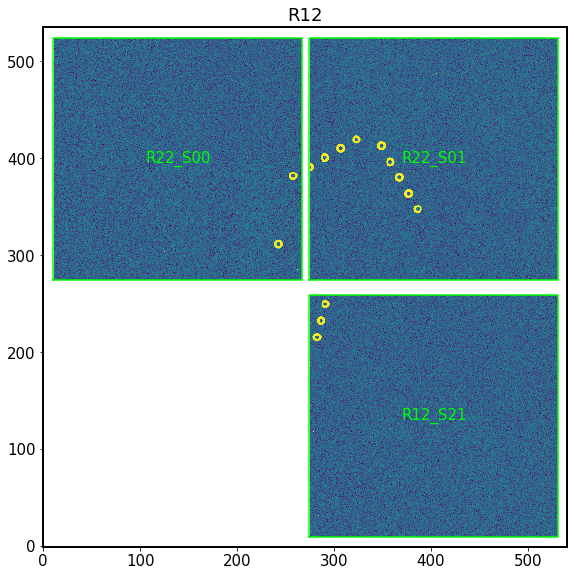

In [48]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.2, wspace=0.0, )

disp = afwDisplay.Display(fig)
disp.scale('asinh', 'zscale', Q=2)

disp.setImageColormap('viridis' if True else 'gray')
dataType = "postISRCCD"

detectorNameList = ['R12_S21','R22_S00','R22_S01'] 
                
i = 1
#for detectorNameList in detectorNameLists:
    
ax = fig.add_subplot(1, 1, i)

raftName = detectorNameList[0][:3]
mos = cameraGeomUtils.showCamera(camera,
                             cameraGeomUtils.ButlerImage(butler, dataType, 
                                                         instrument=instrument, 
                                                         exposure=exposure,
                                                         verbose=True),
                             binSize=16, 
                             detectorNameList=detectorNameList, 
                             display=disp, overlay=True,
                             title=raftName,)
disp.show_colorbar(False)
#ax.axis("off")

i += 1 

## LsstCam, single arrow: try using rotTelPos = 30 

python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/ps1_phosim/testArrow/starSingle_rotSkyPos.inst -i lsst -e 1 -c /project/scichris/aos/ps1_phosim/noBkgnd.cmd -p 25 -o /project/scichris/aos/ps1_phosim/testArrow/lsstCam_rotSkyPos/raw/ > starPhoSim.log 2>&1


    phosim_repackager.py /project/scichris/aos/ps1_phosim/testArrow/lsstCam_rotTelPos/raw/ --out_dir /project/scichris/aos/ps1_phosim/testArrow/lsstCam_rotTelPos/repackaged --inst lsst

Using /project/scichris/aos/ps1_phosim/lsstCam/high/inFocus/DATA


Text(0.5, 1.0, 'LsstCam, R03_S02 (ITL), high latitude, 0.25 sec exp \n quick background')

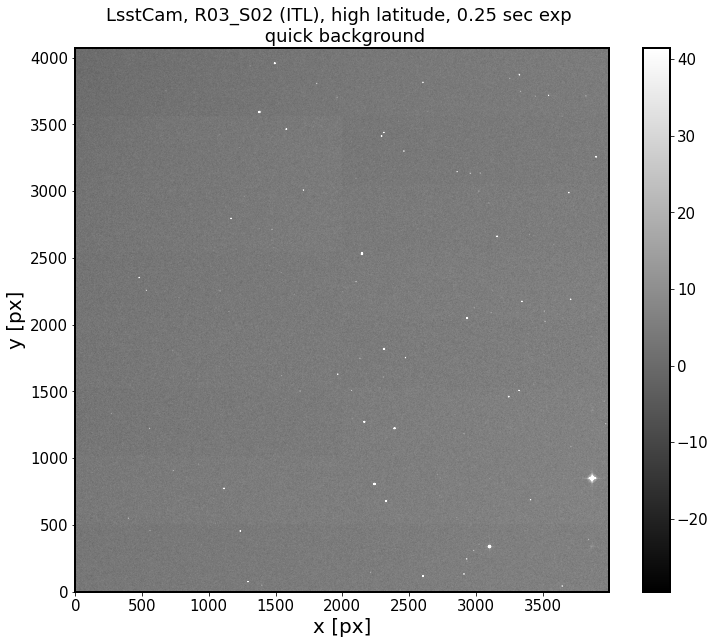

In [44]:



data = exposure.image.array
vmin, vmax = zscale.get_limits(data)

fig = plt.figure(figsize=(12, 10))
plt.imshow(data.T, origin='lower', vmin=vmin,vmax=vmax,cmap='gray')
plt.colorbar()
plt.xlabel('x [px]')
plt.ylabel('y [px]')
detector  = exposure.getDetector()
plt.title(f'LsstCam, {detector.getName()} (ITL), high latitude, 0.25 sec exp \n quick background')

Text(0.5, 1.0, 'LsstCam, R01_S00 (ITL), high latitude, 0.25 sec exp \n backgroundmode 0')

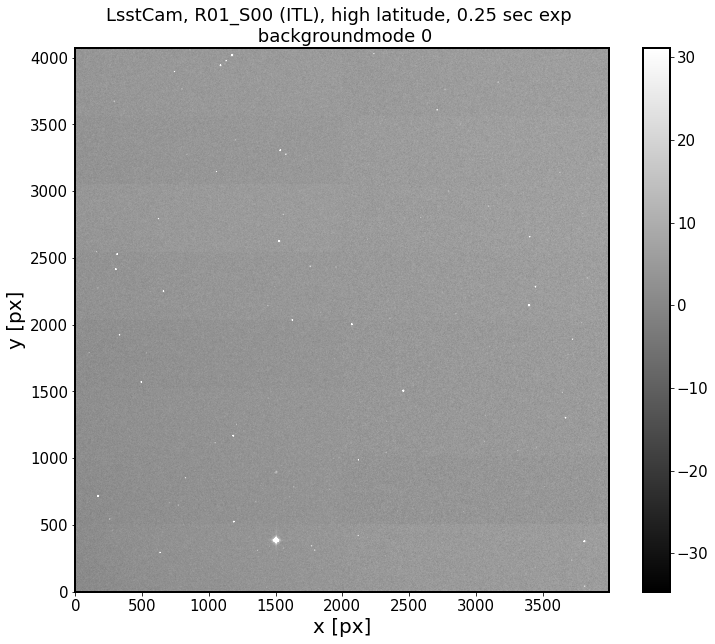

In [11]:
%matplotlib inline

exposure = butler.get('postISRCCD', detector='R01_S00', instrument="LSSTCam",
          exposure=4021123106002,collections=['run1'])
data = exposure.image.array
vmin, vmax = zscale.get_limits(data)

fig = plt.figure(figsize=(12, 10))
plt.imshow(data.T, origin='lower', vmin=vmin,vmax=vmax,cmap='gray')
plt.colorbar()
plt.xlabel('x [px]')
plt.ylabel('y [px]')
detector  = exposure.getDetector()
plt.title(f'LsstCam, {detector.getName()} (ITL), high latitude, 0.25 sec exp \n backgroundmode 0')

Text(0.5, 1.0, 'LsstCam, R10_S00 (ITL), high latitude, 0.25 sec exp \n backgroundmode 0')

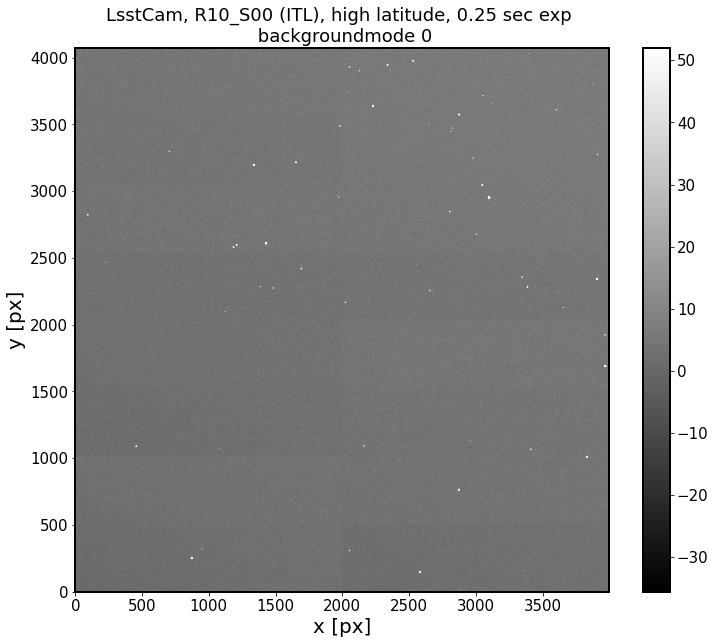

In [12]:
%matplotlib inline

exposure = butler.get('postISRCCD', detector='R10_S00', instrument="LSSTCam",
          exposure=4021123106002,collections=['run1'])
data = exposure.image.array
vmin, vmax = zscale.get_limits(data)

fig = plt.figure(figsize=(12, 10))
plt.imshow(data.T, origin='lower', vmin=vmin,vmax=vmax,cmap='gray')
plt.colorbar()
plt.xlabel('x [px]')
plt.ylabel('y [px]')
detector  = exposure.getDetector()
plt.title(f'LsstCam, {detector.getName()} (ITL), high latitude, 0.25 sec exp \n backgroundmode 0')

In [14]:
vmin

-35.591396

vmin

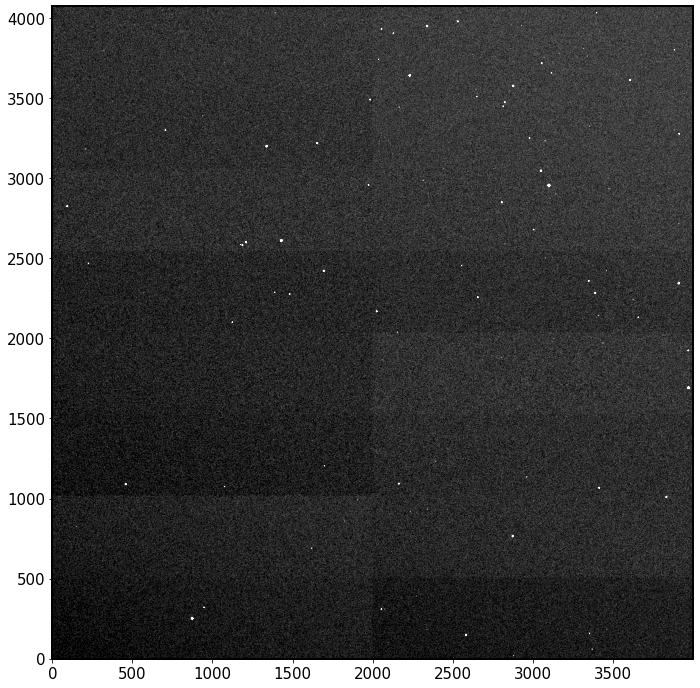

In [18]:
fig = plt.figure(figsize=(14, 12))
plt.imshow(data.T, origin='lower', vmin=0,vmax=25,cmap='gray')

In [ ]:
Check the corner sensors : R00_SWx ,  R04_SWx, R40_SWx,  R44_SWx  , 

-19.932692 40.74462


Text(0.5, 1.0, 'LsstCam, R00_SW0 (ITL), high latitude, 0.25 sec exp \n backgroundmode 0')

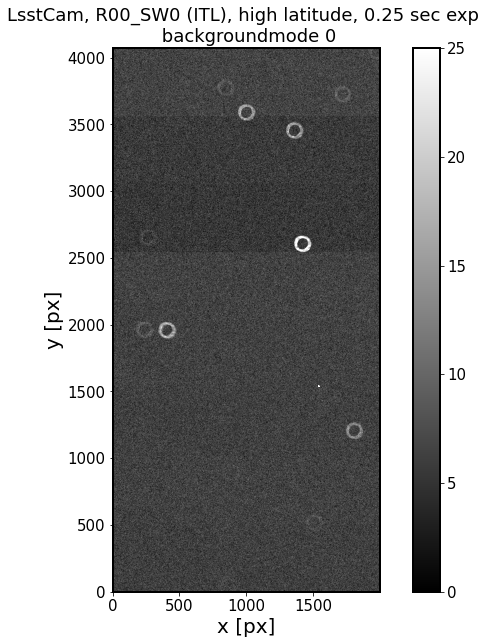

In [32]:
%matplotlib inline

exposure = butler.get('postISRCCD', detector='R00_SW0', instrument="LSSTCam",
          exposure=4021123106002,collections=['run1'])
data = exposure.image.array
vmin, vmax = zscale.get_limits(data)
print(vmin,vmax)
fig = plt.figure(figsize=(12, 10))
plt.imshow(data.T, origin='lower', vmin=0,vmax=25,cmap='gray')
plt.colorbar()
plt.xlabel('x [px]')
plt.ylabel('y [px]')
detector  = exposure.getDetector()
plt.title(f'LsstCam, {detector.getName()} (ITL), high latitude, 0.25 sec exp \n backgroundmode 0')

The corner sensors are all correctly defocal,  but  I still see the ISR issues that I did not see when I was doing the tests... 

# Make a slurm script 


Need to connect to one of the submit nodes https://developer.lsst.io/services/batch.html?highlight=slurm#rubin-batch-systems-overview  eg `lsst-devl03`:

sinfo -Nl  # shows 
scontrol show part  # show resources 


### Slurm example:

In `test1.sl`  put 

    #!/bin/bash -l
    #SBATCH -p debug
    #SBATCH -N 6
    #SBATCH -n 144
    #SBATCH -t 00:10:00
    #SBATCH -J job2

    srun sleep.sh
And in `sleep.sh` put 

    #!/bin/bash
    hostname -f
    echo "Sleeping for 30 ... "
    sleep 30

Ensure that the script is executable: 
    
    chmod 777 sleep.sh
    
Submit to slurm with :
    
    sbatch test1.sl

The results (console output) are in `slurm-50432.out ` since the job got assigned id `50432` 

### Slurm run python script:

In    `testPython.sl`  put: 

    #!/bin/bash -l
    #SBATCH -p debug
    #SBATCH -N 6
    #SBATCH -n 144
    #SBATCH -t 00:10:00
    #SBATCH -J job2

    pwd; hostname; date

    module load python

    echo "Running plot script on a single CPU core"

    python /project/scichris/aos/runPython.py

    date


Submit with 

    sbatch testPython.sl


Check progress: 

In [ ]:
https://www1.psfc.mit.edu/computers/cluster/slurm.html
    
    squeue -u scichris  # shows jobs by that user 
    
    scontrol show jobid 50433  # shows details of a particular jobid 
    
    

In [116]:
a = 23.
for i in range(10):
    print(a)
    a = np.sqrt(a)

23.0
4.795831523312719
2.189938703094842
1.479844148244957
1.2164884496964847
1.1029453520897963
1.050212051011507
1.0247985416712433
1.012323338499732
1.006142802240185
